
# Music Genre Classification based on Audio Analysis

##### Last updated on December 6th, 2022 by Matthew Lynch and Kalonji Harrington


## “Pop” music vs “Popular” music?

When people use the term “*pop music*” they could be referring either to popular music (as in music that is popular or trending) or a more specific genre distinct from metal, jazz, rap, indie, and other established genres. The discussion as to what constitutes the genre of pop music is a complicated one as the genre continuously evolves–branching out and [borrowing musical elements from other styles like rock, dance, Latin, and country music](https://en.wikipedia.org/wiki/Pop_music). The genre of pop also typically aligns with what is currently popular at a given time and Wikipedia suggests *“that the term "pop music" may be used to describe a distinct genre, designed to appeal to all.”* Yet when examining the top hits from the last two decades, there are some tracks that probably wouldn’t be considered as emblematic of the “pop” genre, but rather a subgenre or a different style altogether.

The discussion of popular music is also complex as the current notion of *“good”* music relies heavily on subjective opinions influenced by our culture today. The types of songs that are popular in the United States in 2022 differs from the hit songs of 2005 and might not even be the same as what is currently trending in other countires like Spain or South Korea. Because of this I want to make it clear that the goal of this project is **not to define what** ***"good"*** **music is** but merely to examine trends in the most frequently played tracks.

To clarify, for this project rather than analyzing music from a particular genre, I am analyzing **popular music in the United States from January 1st, 2000 to today** (March 16th, 2022) with the intent of determining if certain combinations of musical qualities are more likely to create hit songs than others. While the process of creating music isn't necessarily so straightforward, information about what the most popular song duration, tempo, key signature, or even volume could provide a guideline for people who wish to create their own popular music.


## Billboard Hot 100

To determine which songs are the most popular, I chose to use [Billboard charts](https://www.billboard.com/charts/). I wanted data on the most popular songs within the United States and for how long they have been popular without relying on a specific streaming service. While music streaming services keep track of how often a song is played, managing to collect the total number of times a given track has been played on different services would be an incredibly time consuming task. When searching for an alternative, I found [Billboard Magazine](https://www.billboard.com/) which focuses its brand on constructing charts and reporting on music news and trends across different genres of music. The Billboard Hot 100 acts as a [music industry standard record chart](https://en.wikipedia.org/wiki/Billboard_Hot_100) and provides information taking into considering all of the most common ways to consume music today. The tooltip on the Hot 100 Charts says the following:

> The week’s most popular songs, ranked by audio and video streaming activity on leading digital music services, radio airplay audience impressions based on monitored airplay and sales data, all compiled by Luminate. Audience totals are derived, in part, using certain Nielsen Audio listener estimates.”

They also provide a variety of charts such as the Billboard Global 200, Billboard Global Excluding US, Hot Country Songs, Top Latin Albums, and more.


### Spotify Web Api

After using the Billboard Hot 100 charts to obtain a list of popular songs, I looked for other websites to scrape relevant song data from. After spending some time looking, I ended up deciding to use [Spotify's Web API](https://developer.spotify.com/). The API provides access to user specfic data such as playlists and saved music alongside more general public data, such as information about the tracks Spotify has access to. This project doesn't need user specific information, so only client side authentication was needed.

After creating an account with Spotify, I created a project on the dashboard to obtain the client side credentials needed to access the Web API. With those credentials I was able to use the python library [spotipy](https://spotipy.readthedocs.io/en/2.19.0/#) to run the API within python. For the authentication, I stored the clientID and clientSecretID on my local device in a file name `config.py` 

If you are trying to run this project yourself, make sure to create a `config.py` on your local device and add your credentials to it. The `import config` will allow this project to access the credentials and subsequently allow proper requests to the Web API.

The Spotify Web API was used to obtain Spotify's audio analysis data which analyzes samples from a given track and records values for duration, loudness, tempo, time signature, tempo, key, and the mode (minor or major) of the song along with the corresponding confidence values.


## Data Collection

Now with all of the basic information covered, we can now go ahead with obtaining the data. Throughout the project, the dataframes are exported to csv files which are considerably faster to read than manually scraping the data gain as there are a lot of weeks in over two decades with each week having 100 songs each.



### Collecting Billboard Top 100 Data

To begin, we first want to scrape the information from the Billboard Hot 100 pages. We're looking to obtain the ranking of each song, the song titles, the artist names, and the number of weeks the song has been in the Hot 100. 

In [3]:
# Import libraries for data collection
import pandas as pd
import requests as rq
from bs4 import BeautifulSoup as bs
import datetime as dt
import re

In [2]:
# Returns a formatted string from a datetime to use when scraping Billboard charts
def format_datetime(datetime):
    return str(datetime.year).zfill(4) + "-" + str(datetime.month).zfill(2) + "-" + str(datetime.day).zfill(2) 

# Returns a formatted string given a string containing artist name(s)
def format_name(name):
    # Fixes the formatting of the ampersand
    amp = re.sub('&amp;', "&", name)
    # Standardizes ways of featuring an artist to "ft."
    ft = re.sub('(Featuring)|(featuring)|(feat\.?)', "ft.", amp)
    return ft

# Removes html tags from a string
def remove_tags(tag, string):
    tag1 ='<' + tag + '.*?>\s*'
    tag2 = '\s*</' + tag + '.*?>'
    return re.sub(tag2, "", re.sub(tag1, "", string))

# Scrapes data from a specified billboard page in a given period of time
def scrape_billboard(start_date, end_date, page):
    info_list = []
    date = start_date
    # Continues to scrape from new pages until the end date is reached
    while date <= end_date:
        # Access the proper url given the date
        billboard_url = "https://www.billboard.com/"  + page + format_datetime(date) + "/"
        soup = bs(rq.get(billboard_url).content)
        # Look for individual song entries
        charts = soup.find_all("div", class_=re.compile('o-chart-results-list-row-container'))
        for entry in charts:
            # Scrape the data from the chart
            rank = remove_tags("span", str(entry.find("span", class_=re.compile('c-label a-font-primary-bold-l'))))
            title = remove_tags("h3", str(entry.find("h3", class_=re.compile('c-title'))))
            artist = remove_tags("span", str(entry.find("span", class_=re.compile('c-label a-no-trucate'))))
            # Properly format the title and artist for ease of use later
            title = format_name(title)
            artist = format_name(artist)
            # Find Last_Week, Peak_Pos, and Wks_on_Chart info
            search = entry.find_all("span", class_=re.compile('(c-label a-font-primary-m lrv-u-padding-tb-050@mobile-max)|(c-label a-font-primary-bold-l a-font-primary-m@mobile-max u-font-weight-normal@mobile-max)'))
            "c-label a-font-primary-bold-l a-font-primary-m@mobile-max u-font-weight-normal@mobile-max"
            # Grab the data on the weeks on the chart
            weeks = remove_tags("span", str(search[2]))

            # Add the data to the info_list
            page_name = "Weeks_in_" + re.sub('charts/|/', "_", page).strip("_")
            data = {'Rank': rank, 'Title': title, 'Artist': artist, 'Week': date, page_name: weeks}
            info_list.append(data)
        # Increment the date by a week (Billboard's charts are on a weekly basis)
        date += dt.timedelta(days = 7)
    # Return a dataframe from the info_list
    return pd.DataFrame(info_list)

# Scrape hot-100 data from 01-01-2000 to today
billboard_data = scrape_billboard(dt.date(2000, 1, 1), dt.date.today(), "charts/hot-100/")
# Track the first and last week a track enters the hot-100 charts instead of each week that the data is in the hot-100
billboard_data.insert(5, "First_Week", billboard_data['Week'], False)
billboard_data.insert(6, "Last_Week", billboard_data['Week'], False)
billboard_data.drop(columns=['Week'], inplace=True)

# Export to a csv to save time in subsequent calls
billboard_data.to_csv("csv/billboard_data_2000_Today.csv")

KeyboardInterrupt: 

While we could have used global data instead of the Hot 100, I chose to use the Hot 100 as I am personally more familiar with the music in the United States. I don't have a reference point for what is popular overseas, so the data within the United States makes more sense for me to process given that I would likely create music for the United States market in mind. It is entirely feasible to look at the different charts instead of the Hot 100 if so desired. The `page` parameter in `scrape_billboard()` allows different charts to be passed using the same function definition.

Additionally, although we haven't finished scraping all of the data (since we haven't used the Spotify Web API just yet), I went ahead and started to format the data just to make additional scraping easier. The Billboard Hot 100 charts formatted ampersands differently, so I replaced their string with a simple ampersand just to make the subsequent regular expressions easier to handle. I also standardized the usage of "Featuring" or "featuring" or "feat." to just be "ft." since consistent expressions are easier to handle.


### Collecting Spotify Data Based On Billboard Data

Now that the data from the Billboard charts has been collected, we can now group the data by the titles (removing duplicate entries) and extract other information using Spotify's API. The grouping is done mainly to save time as otherwise we would be extracting the same information from a song multiple times if it appears on the charts multiple weeks in a row.

In [98]:
# Import libraries for spotipy and the config file needed to authenticate our client
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import config

# Read the billboard data and drop the extra row from the index
billboard_data = pd.read_csv("csv/billboard_data_2022.csv").iloc[:, 1:]

# Group the data properly using the specified aggregation functions
aggregation_functions = {'Rank': "min", 'Weeks_in_hot-100': "max", 'First_Week': "min", 'Last_Week': "max"}
spotify_data = billboard_data.groupby(['Title', 'Artist']).aggregate(aggregation_functions).reset_index()

# Effectively relabel the Rank row as Top Rank
spotify_data.insert(0, "Top_Rank", spotify_data['Rank'], False)
spotify_data.drop(columns=['Rank'], inplace=True)

# Create an instance of spotipy and store the authentication token with the client credential manager
authentication = SpotifyClientCredentials(client_id=config.cid, client_secret=config.csecret)
sp = spotipy.Spotify(client_credentials_manager=authentication)

# Returns an array with all of the analysis data based on the query results given an artist and a song title
def get_audio_analysis(artist, title):
    # Specify the artist to avoid picking a random song
    q = "{} artist:{}".format(title, artist)
    result = sp.search(q, type='track', limit=1)['tracks']['items']
    # Check if the search was sucessful
    if result == []:
        # If the initial search failed, try again specifying w/ the track tag
        q = "track:{} artist:{}".format(title, artist)
        result = sp.search(q, type='track', limit=1)['tracks']['items']
        # Check if it failed again
        if result == []:
            # No result was able to be found
            return [None, None, None, None, None, None, None, None, None, None]
    
    # Get the SpotifyID from the given search (used for uniquely identifying a track)
    if result[0] == None:
        return [None, None, None, None, None, None, None, None, None, None]
    spotify_id = result[0]['id']
    # Try to run the audio analysis (some songs don't have audio analysis yet or don't exist in Spotify's library)
    try:
        analysis = sp.audio_analysis(spotify_id)
    except spotipy.client.SpotifyException:
        # If it failed, no result was found
        return [None, None, None, None, None, None, None, None, None, None]

    # Find the relevant information from the analysis
    duration = analysis['track']['duration']
    loudness = analysis['track']['loudness']
    tempo = analysis['track']['tempo']
    tempo_conf = analysis['track']['tempo_confidence']
    time_sig = analysis['track']['time_signature']
    time_sig_conf = analysis['track']['time_signature_confidence']
    key = analysis['track']['key']
    key_conf = analysis['track']['key_confidence']
    mode = analysis['track']['mode']
    mode_conf = analysis['track']['mode_confidence']
    # Return the array
    return [duration, loudness, tempo, tempo_conf, time_sig, time_sig_conf, key, key_conf, mode, mode_conf]

# Returns an array with all of the features data based on the query results given an artist and a song title
def get_audio_features(artist, title):
    # Specify the artist to avoid picking a random song
    q = "{} artist:{}".format(title, artist)
    result = sp.search(q, type='track', limit=1)['tracks']['items']
    # Check if the search was sucessful
    if result == []:
        # If the initial search failed, try again specifying w/ the track tag
        q = "track:{} artist:{}".format(title, artist)
        result = sp.search(q, type='track', limit=1)['tracks']['items']
        # Check if it failed again
        if result == []:
            # No result was able to be found
            return [None, None, None, None, None, None, None]
    
    # Get the SpotifyID from the given search (used for uniquely identifying a track)
    if result[0] == None:
        return [None, None, None, None, None, None, None]
    spotify_id = result[0]['id']
    # Try to run the audio analysis (some songs don't have audio analysis yet or don't exist in Spotify's library)
    try:
        features = sp.audio_features(spotify_id)
    except spotipy.client.SpotifyException:
        # If it failed, no result was found
        return [None, None, None, None, None, None, None]

    # Find the relevant information from the analysis
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    instrumentalness = features[0]['instrumentalness']
    liveness = features[0]['liveness']
    speechiness = features[0]['speechiness']
    valence = features[0]['valence']
    # Return the array
    return [acousticness, danceability, energy, instrumentalness, liveness, speechiness, valence]

# Returns an array with all of the genres for a given artist (look into updating to get genre per track instead)
def get_genres(artist):
    results = sp.search(q='artist:' + artist, type='artist')
    return results['artists']['items'][0]['genres'] if len(results['artists']['items']) > 0 else None

RUN_SPOTIFY_API = True
if RUN_SPOTIFY_API:
    # Declare empy lists for each variable
    # audio analysis - 10
    duration_list = []
    loudness_list = []
    tempo_list = []
    tempo_conf_list = []
    time_sig_list = []
    time_sig_conf_list = []
    key_list = []
    key_conf_list =[]
    mode_list = []
    mode_conf_list = []
    # audio features - 7
    acousticness_list = []
    danceability_list = []
    energy_list = []
    instrumentalness_list = []
    liveness_list = []
    speechiness_list = []
    valence_list = []
    # Genres
    #total_genre_list = []
    artist_genre_list = []

    # Run the analysis for each unique title in the dataset
    for index, row in spotify_data.iterrows():
        # Create a list of artists, removing all other characters
        string = re.sub('\(|\)', ", ", re.sub('\s+((ft\.)|&|X|x|(\+)|/)\s+', ", ", row['Artist'])).strip(', ')
        artist_list = string.split(",")

        # Try running the analysis until a result if found (sometimes searching an artist wouldn't yield proper results)
        # i.e. "Leave the Door Open" by Silk Sonic, Bruno Mars, ... would only produce a result if Bruno Mars was used
        values = [None, None, None, None, None, None, None, None, None, None]
        more_values = [None, None, None, None, None, None, None]
        for artist in artist_list:
            if values == [None, None, None, None, None, None, None, None, None, None]:
                # Remove parenthesis from the title to avoid the title being too long
                # This was an issue with a Taylor Swift's Christmas Tree Farm (Old Timey Version)
                def_artist = artist
                values = get_audio_analysis(def_artist, re.sub('\(.*\)', "", row['Title']))
                more_values = get_audio_features(def_artist, re.sub('\(.*\)', "", row['Title']))
        
        # Add the results from the analysis to the lists
        duration_list.append(values[0])
        loudness_list.append(values[1])
        tempo_list.append(values[2])
        tempo_conf_list.append(values[3])
        time_sig_list.append(values[4])
        time_sig_conf_list.append(values[5])
        key_list.append(values[6])
        key_conf_list.append(values[7])
        mode_list.append(values[8])
        mode_conf_list.append(values[9])
        acousticness_list.append(more_values[0])
        danceability_list.append(more_values[1])
        energy_list.append(more_values[2])
        instrumentalness_list.append(more_values[3])
        liveness_list.append(more_values[4])
        speechiness_list.append(more_values[5])
        valence_list.append(more_values[6])
        # Get genres
        genres = get_genres(def_artist)
        if genres != None:
            total_genre_list = total_genre_list + list(set(genres) - set(total_genre_list))
        artist_genre_list.append(genres)

    # Add the data to the dataframe
    spotify_data.insert(6, "Duration", duration_list, False)
    spotify_data.insert(7, "Loudness", loudness_list, False)
    spotify_data.insert(8, "Tempo", tempo_list, False)
    spotify_data.insert(9, "Tempo_Confidence", tempo_conf_list, False)
    spotify_data.insert(10, "Meter", time_sig_list, False)
    spotify_data.insert(11, "Meter_Confidence", time_sig_conf_list, False)
    spotify_data.insert(12, "Key", key_list, False)
    spotify_data.insert(13, "Key_Confidence", key_conf_list, False)
    spotify_data.insert(14, "Mode", mode_list, False)
    spotify_data.insert(15, "Mode_Confidence", mode_conf_list, False)
    spotify_data.insert(16, "Acousticness", acousticness_list, False)
    spotify_data.insert(17, "Danceability", danceability_list, False)
    spotify_data.insert(18, "Energy", energy_list, False)
    spotify_data.insert(19, "Instrumentalness", instrumentalness_list, False)
    spotify_data.insert(20, "Liveness", liveness_list, False)
    spotify_data.insert(21, "Speechiness", speechiness_list, False)
    spotify_data.insert(22, "Valence", valence_list, False)
    spotify_data.insert(23, "Artist_Genres", artist_genre_list, False)

# Export the spotify data to a csv
spotify_data.to_csv("csv/spotify_data_2022.csv")

HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/4LaGu95Ui2s4vprSQYWUAZ with Params: {} returned 404 due to analysis not found
HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/72ozIjVFHpAnKGcuYpCfb7 with Params: {} returned 404 due to analysis not found
HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/4LaGu95Ui2s4vprSQYWUAZ with Params: {} returned 404 due to analysis not found
HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/6yuvC80FcnVJNvC0DbXN9e with Params: {} returned 404 due to analysis not found
HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/6yuvC80FcnVJNvC0DbXN9e with Params: {} returned 404 due to analysis not found


KeyboardInterrupt: 

There were a few problems that I encountered when working on using the Spotify Web API to querey results. The first issue was when songs that were on Spotify weren't being properly found. Some songs like *Leave The Door Open* by Bruno Mars, Anderson .Paak, and Silk Sonic had some issues due to how complicated the original artist string was. Directly imported from the Billboard charts, the artist strings for each song could be formatted in multiple different ways. After running the below code, I was able to find patterns in songs that failed to properly query. The solution was converting the artists strings into a list of individual artists who are credited for the song and searching multiple times with each artist to maximize the chance that the correct song is chosen. Another similar issue I noticed was with *Christmas Tree Farm (Old Timey Version)* by Taylor Swift as the parenthesis made the query too long for the API to properly handle.

Additionally some songs don't have the audo analysis available in Spoity's API. Some songs like Camila Cabello's *I'll Be Home for Christmas* is only available on Amazon Music and other songs like Shawn Mendes' *Lost in Japan* didn't have an available audio analysis in the API and returned:

`HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/0BXTqB4It8UM09lCaIY3Jk with Params: {} returned 404 due to analysis not found`

In [4]:
# Read in the Spotify and Billboard data combined
df = pd.read_csv("csv/spotify_data_2022.csv").iloc[:, 1:]
# Create a dataframe with only the missing values
null_data = df[df.isnull().any(axis=1)]

# Print info about missing data
print("Total number of tracks: " + str(len(df.index)))
print("Total number of tracks w/ missing data: " + str(len(null_data.index)))
print("Percentage of data with complete data: " + str(100*(1- len(null_data.index)/len(df.index))) + "%")

# Display some of the missing songs
null_data.head(10)

Total number of tracks: 711
Total number of tracks w/ missing data: 10
Percentage of data with complete data: 98.59353023909986%


,Top_Rank,Title,Artist,Weeks_in_hot-100,First_Week,Last_Week,Duration,Loudness,Tempo,Tempo_Confidence,...,Mode,Mode_Confidence,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Speechiness,Valence,Artist_Genres
41,75,At The End Of A Bar,Chris Young With Mitchell Tenpenny,6,2022-07-30,2022-09-03,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,78,Bubbly,Young Thug With Drake & Travis Scott,12,2022-01-01,2022-01-15,165.06667,-7.572,129.011,0.733,...,0.0,0.362,0.0536,0.910,0.585,0.000000,0.1270,0.2570,0.599,NaN
104,50,Chasing After You,Ryan Hurd With Maren Morris,30,2022-01-15,2022-01-15,207.97379,-6.395,131.912,0.486,...,1.0,0.557,0.7230,0.596,0.679,0.000000,0.1160,0.0394,0.479,NaN
321,13,It's Beginning To Look A Lot Like Christmas,Perry Como And The Fontane Sisters With Mitche...,13,2022-01-01,2022-12-03,155.93333,-12.250,112.874,0.507,...,1.0,0.608,0.7600,0.724,0.276,0.000000,0.1160,0.0599,0.718,NaN
394,37,Meet Me At Our Spot,THE ANXIETY: WILLOW & Tyler Cole,26,2022-01-01,2022-03-19,162.68000,-7.930,94.995,0.185,...,1.0,0.576,0.0153,0.773,0.470,0.000193,0.0851,0.0299,0.399,NaN
405,47,Monster Mash,"Bobby ""Boris"" Pickett And The Crypt-Kickers",39,2022-11-12,2022-11-12,161.50667,-14.980,207.832,0.061,...,0.0,0.414,0.5740,0.391,0.366,0.101000,0.1410,0.0392,0.786,NaN
445,98,Oklahoma Smoke Show,Zach Bryan,1,2022-10-08,2022-10-08,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['oklahoma country']
522,35,Santa Baby,Eartha Kitt With Henri Rene And His Orchestra,3,2022-01-01,2022-01-08,206.06667,-12.346,84.485,0.625,...,1.0,0.510,0.9020,0.700,0.139,0.000000,0.1850,0.0607,0.490,NaN
596,22,Thank God,Kane Brown With Katelyn Brown,11,2022-09-24,2022-12-03,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
690,47,Wishful Drinking,Ingrid Andress With Sam Hunt,20,2022-07-16,2022-11-26,194.54498,-7.317,79.018,0.073,...,1.0,0.497,0.2890,0.678,0.528,0.000000,0.0734,0.0551,0.614,NaN


As we can see, the data is only missing 269 out of 8486 different tracks. In the future I may go back and find other methods of accessing the missing data using other APIs, through I would need to adjust for the potential differences in how the missing data is calculated in comparison to Spotify's audio analysis.

Spotify also had another way of obtaining data through the *Get Tracks' Audio Features* as opposed to the *Get Track's Audio Analysis*, however, I chose not to use the audio features to fill the missing data as the audio features lacks the confidence data that I collected from the audio analysis call. The confidence data is a floating point value from 0 to 1 that indicates the confiendce of Spotify's prediction of a value (key, time signature, etc.). It's also worth noting that Spotify also created their own metrics such as "Acouticness", "Danceability", "Speechiness", and "Valence", but seeing as these metrics were less well defined (i.e. Valence refers to the "musical positiveness conveyed by a track") and the methods for obtaining such data was more ambiguous, I decided to omit them from this dataset.


## Data Representation

The goal now is to make the data more readable and easier to work with. To begin with we can drop the missing data from the dataframe. I would claim that the data is missing at random since there isn't an obvious trend as to why particular songs don't have an audio analysis for them. Additionally the songs that are missing due to not being available on Spotify are also missing at random as the list of popular music was obtained through scraping the Billboard Hot 100 charts which doesn't value which services a song is avaiable through.

The values of some of the columns were also adjusted to go from their floating point representations to strings that are more easily understood. For example, the key of a song is now represented with a letter name as opposed to a float between -1 and 11.

In [5]:
# Read in the Spotify and Billboard data combined
df = pd.read_csv("csv/spotify_data_2022.csv").iloc[:, 1:]
# Drop the missing data
df = df.dropna()

# Returns a string with the correctly formatted time signature (no longer a float)
def display_time_sig(time_sig):
    return str(int(time_sig)) + "/4"

# Returns a string corresponding to the key identified by pitch class
def display_key(key):
    if key == 0:
        return "C"
    elif key == 1:
        return "C#/Db"
    elif key == 2:
        return "D"
    elif key == 3:
        return "D#/Eb"
    elif key == 4:
        return "E"
    elif key == 5:
        return "F"
    elif key == 6:
        return "F#/Gb"
    elif key == 7:
        return "G"
    elif key == 8:
        return "G#/Ab"
    elif key == 9:
        return "A"
    elif key == 10:
        return "A#/Bb"
    elif key == 11:
        return "B"
    else:
        return "Error"

# Returns true if the mode is major
def display_mode(num):
    return "Major" if num > 0 else "Minor"

# Update the columns

df.insert(10, "Meter_Display", df["Meter"].apply(display_time_sig), False)
df.insert(13, "Key_Display", df["Key"].apply(display_key), False)
df.insert(16, "Mode_Display", df["Mode"].apply(display_mode), False)
df.sort_values(by=['Weeks_in_hot-100'], ascending=False, inplace=True)
df.head(20)

,Top_Rank,Title,Artist,Weeks_in_hot-100,First_Week,Last_Week,Duration,Loudness,Tempo,Tempo_Confidence,...,Mode,Mode_Confidence,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Speechiness,Valence,Artist_Genres
264,1,Heat Waves,Glass Animals,91,2022-01-01,2022-10-22,238.80508,-6.900,80.870,0.304,...,1.0,0.420,0.44000,0.761,0.525,0.000007,0.0921,0.0944,0.531,"['gauze pop', 'indietronica', 'shiver pop']"
356,12,Levitating,Dua Lipa,77,2022-01-15,2022-05-07,203.06416,-3.787,102.977,0.925,...,0.0,0.220,0.00883,0.702,0.825,0.000000,0.0674,0.0601,0.915,"['dance pop', 'pop', 'uk pop']"
526,16,Save Your Tears,The Weeknd & Ariana Grande,69,2022-01-15,2022-05-07,215.62666,-5.487,118.051,0.857,...,1.0,0.500,0.02120,0.680,0.826,0.000012,0.5430,0.0309,0.644,"['canadian contemporary r&b', 'canadian pop', ..."
568,2,Stay,The Kid LAROI & Justin Bieber,63,2022-01-01,2022-10-01,141.80576,-5.484,169.928,0.571,...,1.0,0.591,0.03830,0.591,0.764,0.000000,0.1030,0.0483,0.478,"['australian hip hop', 'pop']"
50,8,Bad Habits,Ed Sheeran,56,2022-01-01,2022-07-30,230.74667,-3.745,126.011,0.957,...,0.0,0.654,0.04510,0.807,0.893,0.000028,0.3660,0.0347,0.537,"['pop', 'uk pop']"
667,11,Wasted On You,Morgan Wallen,54,2022-04-09,2022-12-03,178.52000,-5.240,196.000,0.209,...,0.0,0.558,0.37300,0.505,0.657,0.001070,0.1260,0.0318,0.252,"['contemporary country', 'country']"
27,1,All I Want For Christmas Is You,Mariah Carey,53,2022-01-01,2022-12-03,241.10667,-7.463,150.273,0.153,...,1.0,0.471,0.16400,0.336,0.627,0.000000,0.0708,0.0384,0.350,"['dance pop', 'pop', 'urban contemporary']"
692,7,Woman,Doja Cat,52,2022-01-01,2022-08-06,172.62666,-4.175,107.998,0.912,...,0.0,0.615,0.08880,0.824,0.764,0.002940,0.1170,0.0854,0.881,"['dance pop', 'pop']"
232,5,Ghost,Justin Bieber,52,2022-01-01,2022-10-01,153.19011,-5.569,153.960,0.554,...,1.0,0.580,0.18500,0.601,0.741,0.000029,0.4150,0.0478,0.441,"['canadian pop', 'pop']"
121,7,Cold Heart (PNAU Remix),Elton John & Dua Lipa,52,2022-01-01,2022-09-10,202.73546,-6.312,116.032,0.906,...,1.0,0.321,0.03400,0.796,0.798,0.000042,0.0952,0.0317,0.942,"['glam rock', 'mellow gold', 'piano rock']"


In [6]:
import re

def group_genres(column_input):
    column = []
    for row in column_input:
        genre_list = re.findall(r"'([^']*)'", row)
        found_genre = False
        for genre in genre_list:
            if found_genre:
                break
            if "pop" in genre:
                column.append("Pop")
                found_genre = True
            elif "country" in genre or "hillbilly" in genre or "bluegrass" in genre or "cowboy" in genre or "western" in genre:
                column.append("Country")
                found_genre = True
            elif "r&b" in genre or "soul" in genre or "disco" in genre or "funk" in genre or "storm" in genre or "urban" in genre or "motown" in genre:
                column.append("R&B")
                found_genre = True
            elif "blues" in genre or "vandeville" in genre:
                column.append("Blues")
                found_genre = True
            elif "jazz" in genre or "bebop" in genre or "big band" in genre or "blue note" in genre or "dixieland" in genre or "neo" in genre:
                column.append("Jazz")
                found_genre = True
            elif "reggae" in genre:
                column.append("Reggae")
                found_genre = True
            elif ("rap" in genre and "trap" not in genre) or "hip hop" in genre:
                column.append("Rap/Hip-Hop")
                found_genre = True
            elif "rock" in genre or "grunge" in genre or "punk" in genre or "alt" in genre:
                column.append("Rock")
                found_genre = True
            elif "metal" in genre or "core" in genre or "doom" in genre or "death" in genre or "sludge" in genre or "djent" in genre or "drone" in genre or "thrash" in genre:
                column.append("Metal")
                found_genre = True
            elif "dance" in genre or "edm" in genre or "electro" in genre or "house" in genre or "trap" in genre or "dubstep" in genre or "glitch" in genre or "techno" in genre or "trance" in genre or "drill" in genre:
                column.append("Dance")
                found_genre = True
            elif "indie" in genre:
                column.append("Indie")
                found_genre = True
        if found_genre == False:
            column.append("Other")
    return column

df2 = df.apply(lambda x: group_genres(x) if x.name == 'Artist_Genres' else x, axis=0)
df2.head(20)

,Top_Rank,Title,Artist,Weeks_in_hot-100,First_Week,Last_Week,Duration,Loudness,Tempo,Tempo_Confidence,...,Mode,Mode_Confidence,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Speechiness,Valence,Artist_Genres
264,1,Heat Waves,Glass Animals,91,2022-01-01,2022-10-22,238.80508,-6.900,80.870,0.304,...,1.0,0.420,0.44000,0.761,0.525,0.000007,0.0921,0.0944,0.531,Pop
356,12,Levitating,Dua Lipa,77,2022-01-15,2022-05-07,203.06416,-3.787,102.977,0.925,...,0.0,0.220,0.00883,0.702,0.825,0.000000,0.0674,0.0601,0.915,Pop
526,16,Save Your Tears,The Weeknd & Ariana Grande,69,2022-01-15,2022-05-07,215.62666,-5.487,118.051,0.857,...,1.0,0.500,0.02120,0.680,0.826,0.000012,0.5430,0.0309,0.644,R&B
568,2,Stay,The Kid LAROI & Justin Bieber,63,2022-01-01,2022-10-01,141.80576,-5.484,169.928,0.571,...,1.0,0.591,0.03830,0.591,0.764,0.000000,0.1030,0.0483,0.478,Rap/Hip-Hop
50,8,Bad Habits,Ed Sheeran,56,2022-01-01,2022-07-30,230.74667,-3.745,126.011,0.957,...,0.0,0.654,0.04510,0.807,0.893,0.000028,0.3660,0.0347,0.537,Pop
667,11,Wasted On You,Morgan Wallen,54,2022-04-09,2022-12-03,178.52000,-5.240,196.000,0.209,...,0.0,0.558,0.37300,0.505,0.657,0.001070,0.1260,0.0318,0.252,Country
27,1,All I Want For Christmas Is You,Mariah Carey,53,2022-01-01,2022-12-03,241.10667,-7.463,150.273,0.153,...,1.0,0.471,0.16400,0.336,0.627,0.000000,0.0708,0.0384,0.350,Pop
692,7,Woman,Doja Cat,52,2022-01-01,2022-08-06,172.62666,-4.175,107.998,0.912,...,0.0,0.615,0.08880,0.824,0.764,0.002940,0.1170,0.0854,0.881,Pop
232,5,Ghost,Justin Bieber,52,2022-01-01,2022-10-01,153.19011,-5.569,153.960,0.554,...,1.0,0.580,0.18500,0.601,0.741,0.000029,0.4150,0.0478,0.441,Pop
121,7,Cold Heart (PNAU Remix),Elton John & Dua Lipa,52,2022-01-01,2022-09-10,202.73546,-6.312,116.032,0.906,...,1.0,0.321,0.03400,0.796,0.798,0.000042,0.0952,0.0317,0.942,Rock


In [7]:
print(len(pd.unique(df2['Artist_Genres'])))

11


Here we see we found 11 of the 12 genres in the dataset given our method of selection. 

# Unsupervised Learning

To begin the analysis, let's examine whether genres from the Billboard Top 100 can be easily grouped by their musical qualities even without being given the correct labels. We'll use unsupervised learning techniques to examine how well the data is clustered into different genres. 

## K-Means Clustering

The first clustering method will be a standard K-Means clustering algorithm. Given a hyperparameter K, this algorithm will randomly place K centroids and adjust them to best separate the data into K clusters. A good clustering is defined by a small error between a centroid and members of its cluster and a large distance bewteen centroids. 

The first step is to choose the K hyperparameter. As shown above, there are actually 11 genres to classify, so K of 11 would make sense. But let's see if a hyperparameter curve will show that there should be 11 centroids. This curve will plot a clustering metric for the data over different K values. The Silhouette score is the metric used to evaluate the clustering in this case. This metric measures both the error within the cluster and the distance between clusters. All scores are within [-1, 1] with a higher score indicating tight clusters that a very well-separated, while a negative score indicates overlapping clusters. A score close to 0 indicate the data is uniformly distributed throughout the Euclidean space, meaning clusters do not overlap but do not form distinct groups either. 

More informationn about the silhouette score can be found here: 
https://arxiv.org/abs/1905.05667
https://www.sciencedirect.com/science/article/pii/0377042787901257 

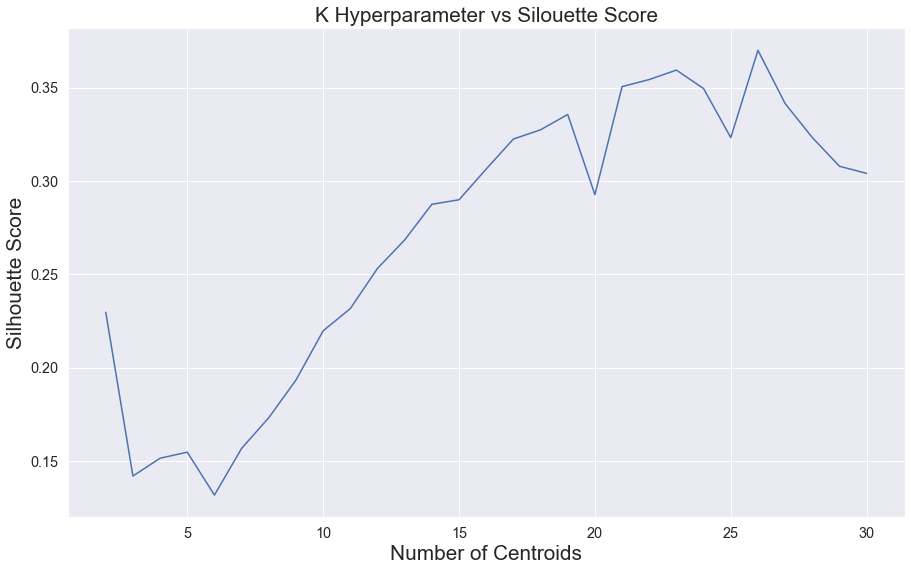

In [20]:
import sklearn.model_selection as sk_ms
from sklearn import metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# plots a hyperparameter curve for the passed input data for the k values passed
# the evaluation metric will be the silhouette score, which scores models based
# on the error within a cluster and the separation between clusters
def kMeansHyperparameterCurve(X, kVals):
    results = []

    for k in kVals:
        model = KMeans(k)

        model.fit(X)

        results.append(metrics.cluster.silhouette_score(X, model.labels_))

    fig = plt.figure(1, (15, 9))

    plt.title("K Hyperparameter vs Silouette Score", fontsize='xx-large')
    plt.xlabel("Number of Centroids", fontsize='xx-large')
    plt.ylabel("Silhouette Score", fontsize='xx-large')
    plt.xticks(fontsize="large")
    plt.yticks(fontsize="large")

    plt.plot(kVals, results)
    plt.show()

# select columns of interest (those related to musical qualities) for input data
X = df2[["Duration", "Loudness", "Tempo", "Tempo_Confidence", "Meter", "Meter_Confidence", "Key", "Key_Confidence", "Mode", "Mode_Confidence", "Acousticness", "Danceability", "Energy", "Instrumentalness", "Liveness", "Speechiness", "Valence"]]

# generate a one-hot-encoding for each categorical variable
X = pd.get_dummies(X, columns=["Meter", "Key", "Mode"])

numeric_cols = ["Duration", "Loudness", "Tempo", "Tempo_Confidence", "Meter_Confidence", "Key_Confidence", "Mode_Confidence", "Acousticness", "Danceability", "Energy", "Instrumentalness", "Liveness", "Speechiness", "Valence"]
# normalize the numberical variables
X[numeric_cols] = X[numeric_cols].apply(lambda col : (col - col.min()) / (col.max() - col.min()), axis = 0)

# plot a curve for integer Ks in [2, 30]
kMeansHyperparameterCurve(X, range(2, 31))

A K of 26 has the best silhouette score of about 0.375, with 11 having a relatively low score of around 0.25. Both of these scores are not incredibly close to 0, but are close enough to indicate that the data does not separate very well into distinct groups. There is some separation, but not so much that there are well-defined grouping for the algorithm to latch onto. If this is the case, then it is unlikely that any accurate genre groupings can be generated based on a distance metric. 

Just to be sure, let's take a look at how a K-Means with K = 11 groups, for each of the different genres. To measure this, a contingency matrix that displays the number of entries with each label in each genre can be generated using the pandas crosstab function. This can then be displayed graphically using a heatmap. A good clustering of the genres would mean that each genre is concentrated within one label and that label is different for each genre. 

Silhouette Score for 11 centroids: 
0.23401670706843616


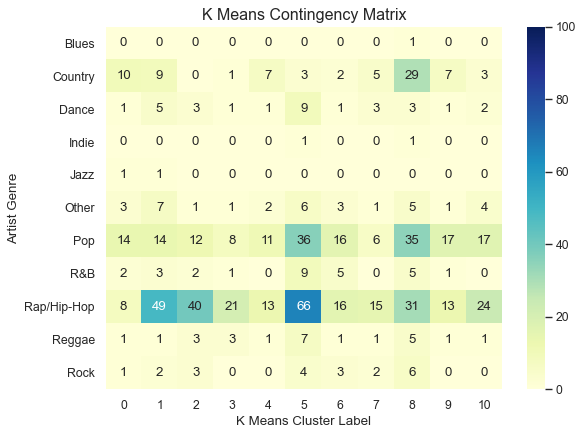

In [9]:
import seaborn as sns; sns.set()

Y = df2["Artist_Genres"]

k = len(pd.unique(Y)) # set k to be actual number of genres

model = KMeans(k)

model.fit(X)

# show silhoetter score for model
print(f"Silhouette Score for {k} centroids: ")
print(metrics.cluster.silhouette_score(X, model.labels_))

# generate contingency matrix of genres vs. labels
contigency = pd.crosstab(Y, model.labels_, rownames=["Artist Genre"], colnames=["K Means Cluster Label"])

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.clf()

plt.title("K Means Contingency Matrix", fontsize='large')

# display as a heatmap
res = sns.heatmap(contigency, annot=True, fmt='d', cmap="YlGnBu", vmin=0.0, vmax=100.0)

plt.show()

And now with the optimal k = 26 based on the Silhoette Score. 

Silhouette Score for 26 centroids: 
0.33295587072959526


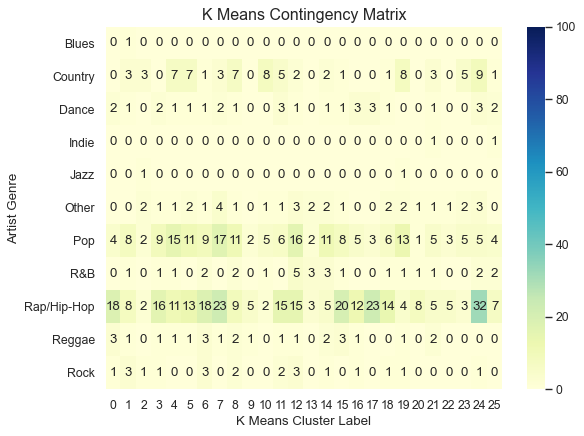

In [23]:
import seaborn as sns; sns.set()

Y = df2["Artist_Genres"]

k = 26 # set k to be optimal k from hyperparameter curve

model = KMeans(k)

model.fit(X)

print(f"Silhouette Score for {k} centroids: ")
print(metrics.cluster.silhouette_score(X, model.labels_))

contigency = pd.crosstab(Y, model.labels_, rownames=["Artist Genre"], colnames=["K Means Cluster Label"])

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.clf()

plt.title("K Means Contingency Matrix", fontsize='large')

res = sns.heatmap(contigency, annot=True, fmt='d', cmap="YlGnBu", vmin=0.0, vmax=100.0)

plt.show()

Examining the heat maps, there are a couple of important things to note. The first is that very few genres with a sizable (> 10) number of examples were very well concentrated within a single label. For k = 11, the only sizeable genre with any noticeable grouping was Country, which had more than half of its examples in label 8, although pop and rap/hip-hop dominated that label. For k = 26, this grouping is entirely destroyed, showing that a higher Silhouette Score does not necessarily lead to a better grouping in terms of genres. It is possible that the Silhouette Score is correctly finding better clustering within the data, but this clustering may be based on a property different from the genre. It seems as though none of the genres are very well-separated from the others, just as the silhouette score indicated. 

The other observation worthy of note is that the classes are not evenly-sized. There are very few observations for genres like Blue and Jazz, and very many for Pop and Rap/Hip-Hop. K-Means does not perform very well on datasets that do not have an even cluster size, so another clustering method may be more suitable for this task. 

## Mean-Shift Clustering

Mean-Shift Clustering is another clustering algorithm that, rather than having a set number of clusters, seeks to find the most dense part of a region within a search space. This makes the algorithm much more effective with uneven cluster sizes and smooth densities of samples. However, it does make the algorithm more susceptible to outliers since the number of centroids is not controlled and outliers can form their own "dense" regions. Since our problem seems to suffer from both a more uniform distribution of points and very uneven cluster sizes, this algorithm should see some improvement over K-Means.

The hyperparameter that Mean-Shift Clustering offers is the bandwidth of the kernel, which controls the size of the search space for the centroids. There are many factors to take into account when choosing this hyperparameter, but for simplicity's sake we will just consider one: the Silhouette Score. 

For more information, see these sources:

https://scikit-learn.org/stable/modules/clustering.html#mean-shift
https://www.geeksforgeeks.org/ml-mean-shift-clustering/
https://ieeexplore.ieee.org/document/1000236

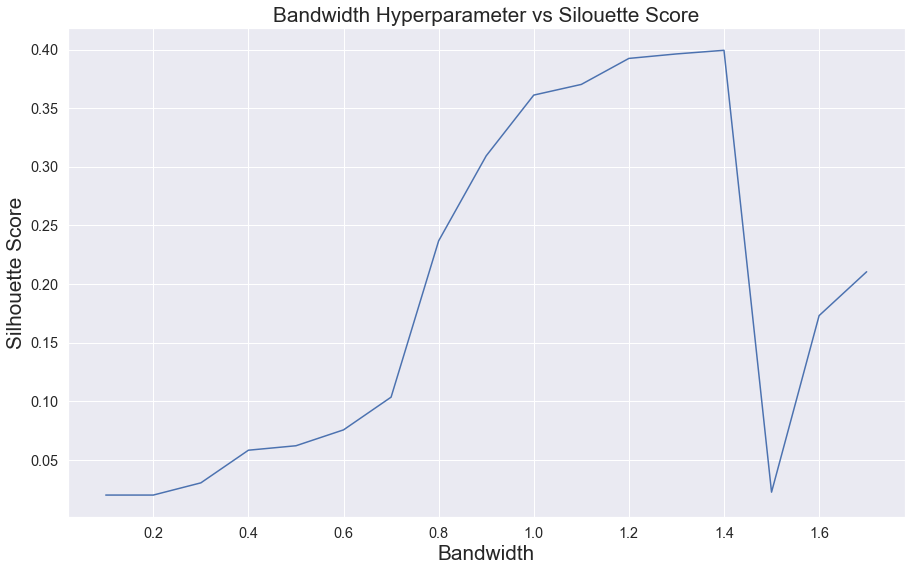

In [26]:
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth
import numpy as np

# plots a hyperparameter curve for the passed input data for the bandwidth values passed
# the evaluation metric will be the silhouette score, which scores models based
# on the error within a cluster and the separation between clusters
def meanShiftHyperparameterCurve(X, bandVals):
    scores = []

    for band in bandVals:
        model = MeanShift(bandwidth=band)

        model.fit(X)

        scores.append(metrics.cluster.silhouette_score(X, model.labels_))

    fig = plt.figure(1, (15, 9))

    plt.title("Bandwidth Hyperparameter vs Silouette Score", fontsize='xx-large')
    plt.xlabel("Bandwidth", fontsize='xx-large')
    plt.ylabel("Silhouette Score", fontsize='xx-large')
    plt.xticks(fontsize="large")
    plt.yticks(fontsize="large")

    plt.plot(bandVals, scores)
    plt.show()    

# generate curve for 
meanShiftHyperparameterCurve(X, np.linspace(0.1, 1.7, 17))

This hyperparameter curve shows that Mean-Shift is able to acheive a higher silhouette score than K-Means as expected. However, 0.4 is still not a very high Silhouette Score. Furthermore, just as was the case with K-Means, this does not necessarily mean that the clustering achieved corresponds well to the genre classifications. This is even more so the case with Mean-Shift, since the number of clusters is not controlled. 

Given this information, let's run Mean-Shift with the bandwidth that maximized the Silhouette score and see how well the labels correspond to the classes. 

Silhouette Score for bandwidth 1.4: 
0.39938605144762446


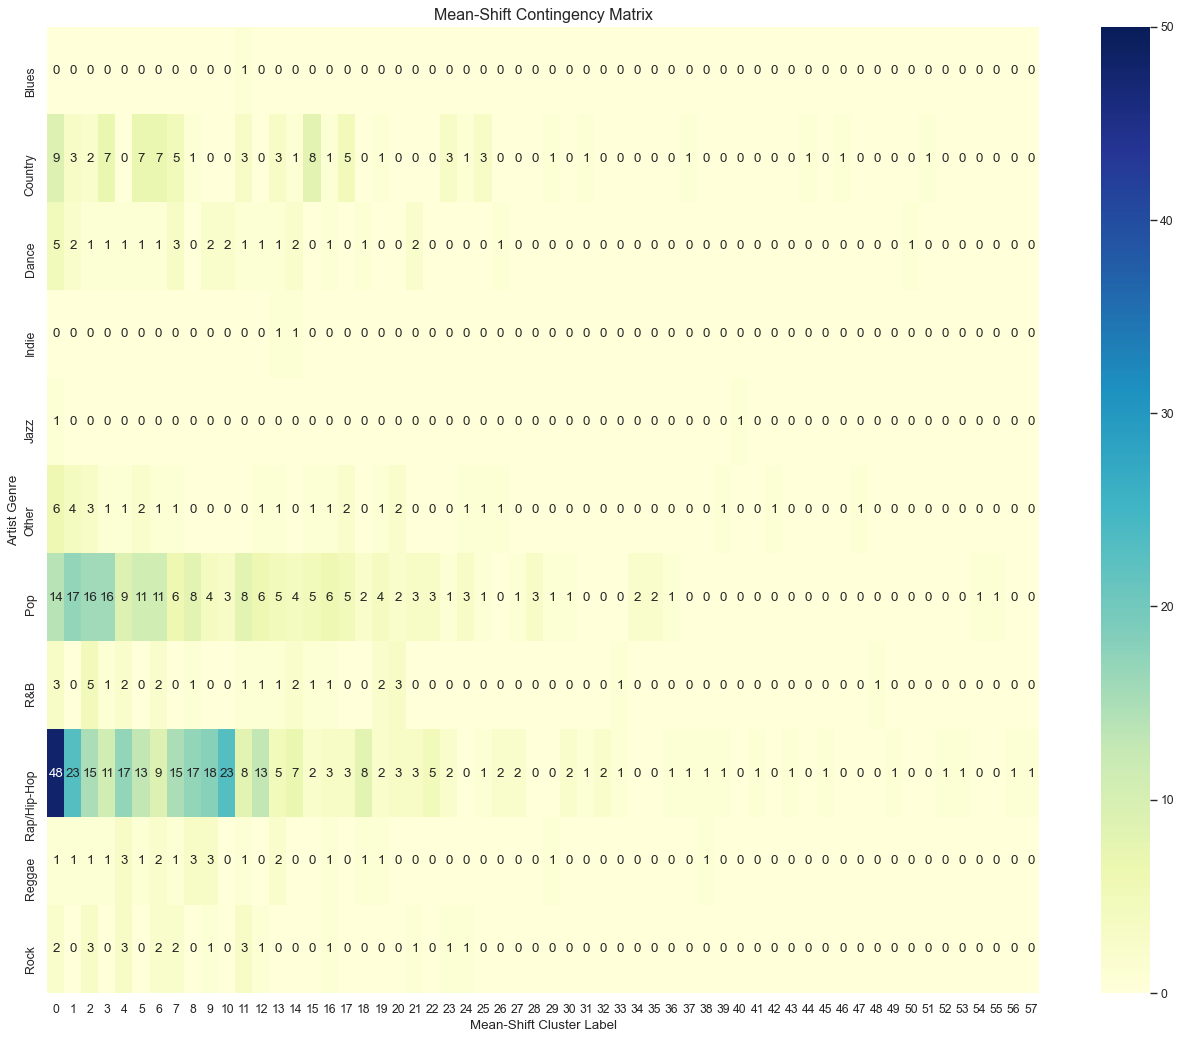

In [11]:
band = 1.4
model = MeanShift(bandwidth=band)

model.fit(X)

print(f"Silhouette Score for bandwidth {band}: ")
print(metrics.cluster.silhouette_score(X, model.labels_))

contigency = pd.crosstab(Y, model.labels_, rownames=["Artist Genre"], colnames=["Mean-Shift Cluster Label"])

fig = plt.figure(num=None, figsize=(20, 16), dpi=80, facecolor='w', edgecolor='k')

plt.clf()

plt.title("Mean-Shift Contingency Matrix", fontsize='large')

res = sns.heatmap(contigency, annot=True, fmt='d', cmap="YlGnBu", vmin=0.0, vmax=50.0)

plt.show()

Even though Mean-Shift is able to achieve a higher Silhouette score, it's grouping of genres is not much improved. This is in large part due to the algorithm creating a much larger number of clusters because of outliers creating very small clusters. Even Country, a genre K-Means was able to group fairly well under a single label, is not well-classified using Mean-Shift. So K-Means seems to be a much better clustering algorithm for the data we have despite Mean-Shift's advantages. 

## K-Means Revisited

Both K-Means and Mean-Shift have shown significant flaws when used on the current dataset. However, K-Means showed some potential when classifing one of the larger genres, despite its lower Silhouette Score. Since K-Means may struggle with the imbalanced sizes of classes in the dataset, focusing on only the largest classes with fewer clusters may help the algorithm with its separation. Now we'll examine how the algorithm performs with only a few of the most popular genres. 

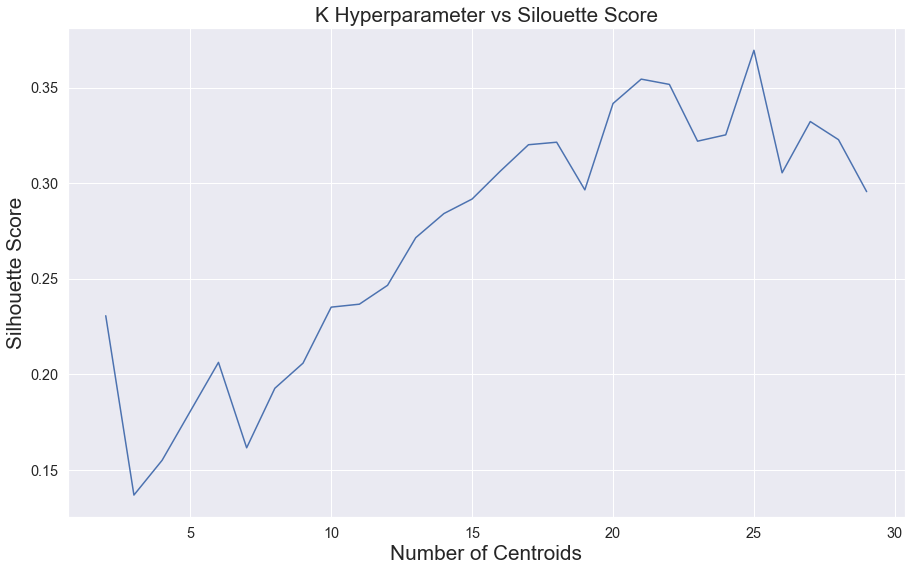

In [29]:
# select the most popular genres
toSelect = ["Pop", "Rap/Hip-Hop", "Country"]
reduced = df2.loc[df2["Artist_Genres"].isin(toSelect)]

# generate the new input data similar to the full dataset
X2 = reduced[["Duration", "Loudness", "Tempo", "Tempo_Confidence", "Meter", "Meter_Confidence", "Key", "Key_Confidence", "Mode", "Mode_Confidence", "Acousticness", "Danceability", "Energy", "Instrumentalness", "Liveness", "Speechiness", "Valence"]]
X2 = pd.get_dummies(X2, columns=["Meter", "Key", "Mode"])

numeric_cols = ["Duration", "Loudness", "Tempo", "Tempo_Confidence", "Meter_Confidence", "Key_Confidence", "Mode_Confidence", "Acousticness", "Danceability", "Energy", "Instrumentalness", "Liveness", "Speechiness", "Valence"]

X2[numeric_cols] = X2[numeric_cols].apply(lambda col : (col - col.min()) / (col.max() - col.min()), axis = 0)

# plot a curve for 
kMeansHyperparameterCurve(X2, np.array(range(2, 30)))

The Silhouette Score has not changed much, suggesting the separation has not improved. Let's see how the genres were grouped. 

Silhouette Score for 3 centroids: 
0.13683175915183982


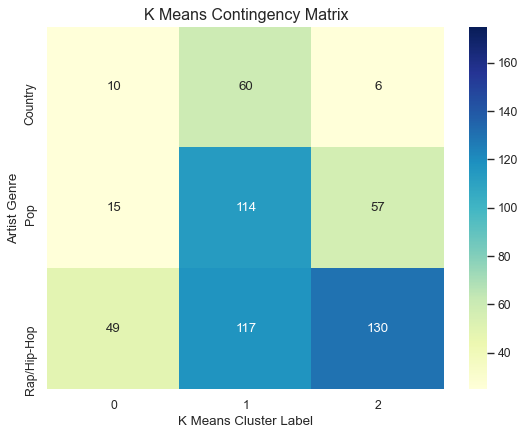

In [30]:
Y2 = reduced["Artist_Genres"]

k = len(pd.unique(Y2))

model = KMeans(k)

model.fit(X2)

print(f"Silhouette Score for {k} centroids: ")
print(metrics.cluster.silhouette_score(X2, model.labels_))

contigency = pd.crosstab(Y2, model.labels_, rownames=["Artist Genre"], colnames=["K Means Cluster Label"])

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.clf()

plt.title("K Means Contingency Matrix", fontsize='large')

res = sns.heatmap(contigency, annot=True, fmt='d', cmap="YlGnBu", vmin=25.0, vmax=175.0)

plt.show()

The reduction in the number of classes seems to have caused Country to group more into a single class, though the class is still dominated by Pop and Rap/Hip-Hop. Class 2 also shows some improvement, as it clustered mainly around Rap/Hip-Hop songs, with those making up more than double the other class, although this is almost certainly influenced by the differing number of examples for each genre within the dataset. 

## Conclusion

Overall, these clustering algorithms have not been successful at grouping songs by genre based on their musical qualities. Using a distance-based approach does not seem to yield the necessary amount of separation between genres making it so that a single genre can be spread across many groups as it overlaps with other genres in the Euclidean space. While the Silhouette Score indicates that there is some separation, this separation may not be based on the genres per se, but rather another attribute of the music, such as the artist who wrote it or the year it was made in. This is a limitation of unsupervised learning, which does not specify exactly what attribute is being classified/optimized. 

That being said, the genres for each song are available with this data, so supervised learning is a good next step for analyzing this data and finding useful insights. 

# Supervised Learning
## One Versus All

In [12]:
from sklearn.multiclass import OneVsRestClassifier

train, test = sk_ms.train_test_split(df, train_size=0.7)

2


In [ ]:
from sklearn.linear_model import LogisticRegression

In [75]:
MGD_songs = pd.read_csv("Hit_Songs/spotify_hits_dataset_complete.csv", delimiter="\t")
MGD_songs["artist_name"] = MGD_songs["artist_name"].apply(lambda artists : artists[1:-1].split(","))
MGD_songs = pd.get_dummies(MGD_songs, columns=["explicit", "song_type", "key", "mode", "time_signature"])
print(MGD_songs.columns)
MGD_songs.head(10)

Index(['song_id', 'song_name', 'artist_id', 'artist_name', 'popularity',
       'track_number', 'num_artists', 'num_available_markets', 'release_date',
       'duration_ms', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence',
       'tempo', 'explicit_False', 'explicit_True', 'song_type_Collaboration',
       'song_type_Solo', 'key_0', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5',
       'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'mode_0',
       'mode_1', 'time_signature_1', 'time_signature_3', 'time_signature_4',
       'time_signature_5'],
      dtype='object')


,song_id,song_name,artist_id,artist_name,popularity,track_number,num_artists,num_available_markets,release_date,duration_ms,...,key_8,key_9,key_10,key_11,mode_0,mode_1,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,16GAMmkIzTIT7aH19TtW3f,Show You,['6M25WWmNO7wK1DnKmd3z6R'],['CXLOE'],45,1,1,79,2018-08-03,191235,...,0,0,0,0,1,0,0,0,1,0
1,0MET90crciVlxlE07ub7Rn,Good Love (feat. Tory Lanez),"['3dKjmeRZcSUw617CoMzEA0', '2jku7tDXc6XoB6MO2h...","['Nafe Smallz', 'Tory Lanez']",58,1,2,79,2019-06-21,192000,...,1,0,0,0,1,0,0,1,0,0
2,7BpYWzZwrsljT1eIjb0TqR,Told You So,['74XFHRwlV6OrjEM0A2NCMF'],['Paramore'],61,3,1,79,2017-05-12,188946,...,0,0,0,0,1,0,0,0,1,0
3,2GrYIUrAYK5TZhSh0RJV6H,Fantastic Boy,['4Kxlr1PRlDKEB0ekOCyHgX'],['BIGBANG'],0,4,1,0,2011-04-08,232586,...,0,0,0,1,1,0,0,0,1,0
4,7G7P0AOE4mXWvdSSroLfZA,Told You,['31lnFZEM6ysvjOx59VyxRE'],['Krept & Konan'],0,2,1,0,2017-10-20,152213,...,1,0,0,0,0,1,0,0,1,0
5,3B9LeuYJssQeocPce7eANk,Dans mon nuage,['37ioGUZGhKk7VjWIocx8kM'],['DTF'],38,3,1,79,2017-05-19,186099,...,0,0,0,0,1,0,0,0,1,0
6,6FxCPvx8Ovm9y77DO6vuy5,"Main Title ""Somewhere in My Memory"" (From ""Hom...","['3dRfiJ2650SZu6GbydcHNb', '7CIcEIOiWaZcEH35cp...","['John Williams', 'Boston Pops Orchestra']",27,9,2,78,1970,294133,...,0,0,0,0,0,1,0,0,1,0
7,0ZOLmB0W7ffKzdz3ipZBFW,Bulma,['2s7fZ34RK8RUJQ2ewsh6I5'],['RK'],42,16,1,79,2019-04-05,181901,...,0,0,0,0,1,0,0,0,1,0
8,2uq4DBILXSbWlpwH101qwr,Pankani,['4vtz0m60CCrcsQmqDunDIR'],['Moha La Squale'],41,12,1,79,2018-05-25,173000,...,0,0,0,1,1,0,0,0,1,0
9,3cdxShmWeMHolKPDi3SRXM,Menace,['3NH8t45zOTqzlZgBvZRjvB'],['PNL'],57,13,1,79,2019-04-05,188864,...,1,0,0,0,0,1,0,0,1,0


In [50]:
MGD_artists = pd.read_csv("Artists/spotify_artists_info_complete_reduced_genres.csv", delimiter="\t")
MGD_artists.head(10)

,artist_id,name,followers,popularity,genres,image_url
0,1WgXqy2Dd70QQOU7Ay074N,AURORA,923204,75,['pop'],https://i.scdn.co/image/87b5228e7ab1c8cc2cf4ec...
1,2dXKh2aHr7RS2RVPlWJoUS,MHD,2707,24,[],https://i.scdn.co/image/ab67616d0000b273c4141b...
2,293zczrfYafIItmnmM3coR,Chuck Berry,1103439,67,"['soul', 'roots rock', 'folk rock', 'rock', 'c...",https://i.scdn.co/image/d58323616d4f5d22b51e9d...
3,4DqRDyrUuJO8CuxfgVCU3m,Hasan.K,38,29,[],NaN
4,1U5zgr455OGyIkLNXvDdrf,Traditional,26672,64,['other'],https://i.scdn.co/image/ab67616d0000b273765aa4...
5,3OZZeMIZnTvQKjfQEEqx6C,The Kingdom Choir,7789,42,[],https://i.scdn.co/image/98fd09c1a30f33af7666a3...
6,4sVieJlKgpZ2k9ESNS5IdN,Jamule,97997,71,['hip hop'],https://i.scdn.co/image/4c4d11fa1e9ba69a532803...
7,3t8WiyalpvnB9AObcMufiE,Mahmut Orhan,363044,59,"['electro', 'house']",https://i.scdn.co/image/3f17566bcb7448810e14ad...
8,2wUjUUtkb5lvLKcGKsKqsR,Alessia Cara,7037537,82,"['r&b', 'pop', 'dance pop', 'electropop']",https://i.scdn.co/image/56dcc0e8f919ea86b139b4...
9,66TrUkUZ3RM29dqeDQRgyA,Ella Eyre,563949,70,"['pop', 'dance pop', 'tropical house']",https://i.scdn.co/image/8525e31ee091ab322e5b35...
